<a href="https://colab.research.google.com/github/MONISHKA1607/Accelerated_Data_Science_UCS547/blob/main/Assignment3_CUDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Q1 Write a CUDA C/C++ program to perform element-wise addition of two vectors.

C[i]=A[i]+B[i]

Given: Vector size: N = 1024

In [3]:
%%writefile vector_add.cu
#include<stdio.h>
#include<cuda_runtime.h>

#define N 1024

__global__ void vectorAdd(int *A, int *B, int *C) {
    int id = blockIdx.x * blockDim.x + threadIdx.x;
    if(id < N)
        C[id] = A[id] + B[id];
}

int main() {

    int *h_A, *h_B, *h_C;
    int *d_A, *d_B, *d_C;

    int size = N * sizeof(int);

    h_A = (int*)malloc(size);
    h_B = (int*)malloc(size);
    h_C = (int*)malloc(size);

    for(int i=0;i<N;i++){
        h_A[i] = i;
        h_B[i] = i;
    }

    cudaMalloc((void**)&d_A, size);
    cudaMalloc((void**)&d_B, size);
    cudaMalloc((void**)&d_C, size);

    cudaMemcpy(d_A, h_A, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, size, cudaMemcpyHostToDevice);

    vectorAdd<<<(N+255)/256,256>>>(d_A,d_B,d_C);

    cudaMemcpy(h_C, d_C, size, cudaMemcpyDeviceToHost);

    printf("First 10 results:\n");
    for(int i=0;i<10;i++)
        printf("%d ", h_C[i]);

    printf("\n");

    cudaFree(d_A); cudaFree(d_B); cudaFree(d_C);
    free(h_A); free(h_B); free(h_C);

    return 0;
}


Writing vector_add.cu


In [4]:
!nvcc -arch=sm_75 vector_add.cu -o vector_add

In [5]:
!./vector_add

First 10 results:
0 2 4 6 8 10 12 14 16 18 


Q2 Perform the same vector addition as in Q1 using Thrust library only.

In [6]:
%%writefile thrust_add.cu
#include<thrust/device_vector.h>
#include<thrust/host_vector.h>
#include<iostream>

#define N 1024

int main(){

    thrust::host_vector<int> h_A(N), h_B(N);

    for(int i=0;i<N;i++){
        h_A[i] = i;
        h_B[i] = i;
    }

    thrust::device_vector<int> d_A = h_A;
    thrust::device_vector<int> d_B = h_B;
    thrust::device_vector<int> d_C(N);

    thrust::transform(d_A.begin(), d_A.end(),
                      d_B.begin(),
                      d_C.begin(),
                      thrust::plus<int>());

    thrust::host_vector<int> h_C = d_C;

    std::cout << "First 10 results:\n";
    for(int i=0;i<10;i++)
        std::cout << h_C[i] << " ";

    std::cout << std::endl;

    return 0;
}

Writing thrust_add.cu


In [7]:
!nvcc -arch=sm_75 thrust_add.cu -o thrust_add

In [8]:
!./thrust_add

First 10 results:
0 2 4 6 8 10 12 14 16 18 


Q3 Compute the dot product of two vectors of size, N =1024:

 Result=∑A[i]×B[i]

 using Thrust and compare its performance with that on CPU.

In [9]:
%%writefile thrust_dot.cu
#include<thrust/device_vector.h>
#include<thrust/host_vector.h>
#include<thrust/inner_product.h>
#include<iostream>
#include<chrono>

#define N 1024

int main(){

    thrust::host_vector<int> h_A(N), h_B(N);

    for(int i=0;i<N;i++){
        h_A[i] = i;
        h_B[i] = i;
    }

    auto start_cpu = std::chrono::high_resolution_clock::now();
    long long cpu_result = 0;
    for(int i=0;i<N;i++)
        cpu_result += h_A[i]*h_B[i];
    auto end_cpu = std::chrono::high_resolution_clock::now();

    thrust::device_vector<int> d_A = h_A;
    thrust::device_vector<int> d_B = h_B;

    auto start_gpu = std::chrono::high_resolution_clock::now();
    int gpu_result = thrust::inner_product(d_A.begin(), d_A.end(),
                                           d_B.begin(), 0);
    auto end_gpu = std::chrono::high_resolution_clock::now();

    std::cout << "CPU Result: " << cpu_result << std::endl;
    std::cout << "GPU Result: " << gpu_result << std::endl;

    return 0;
}


Writing thrust_dot.cu


In [10]:
!nvcc -arch=sm_75 thrust_dot.cu -o thrust_dot

In [11]:
!./thrust_dot

CPU Result: 357389824
GPU Result: 357389824


Q4 Write a CUDA kernel for matrix multiplication:

C=A×B

where Matrix size is 16X 16. Explain why matrix multiplication needs more computation than addition (as in Q1).

In [12]:
%%writefile matrix_mul.cu
#include<stdio.h>
#define N 16

__global__ void matMul(int *A, int *B, int *C){
    int row = threadIdx.y;
    int col = threadIdx.x;

    int sum = 0;
    for(int k=0;k<N;k++)
        sum += A[row*N + k] * B[k*N + col];

    C[row*N + col] = sum;
}

int main(){

    int A[N*N], B[N*N], C[N*N];

    for(int i=0;i<N*N;i++){
        A[i] = 1;
        B[i] = 1;
    }

    int *d_A, *d_B, *d_C;
    int size = N*N*sizeof(int);

    cudaMalloc(&d_A,size);
    cudaMalloc(&d_B,size);
    cudaMalloc(&d_C,size);

    cudaMemcpy(d_A,A,size,cudaMemcpyHostToDevice);
    cudaMemcpy(d_B,B,size,cudaMemcpyHostToDevice);

    dim3 threads(N,N);
    matMul<<<1,threads>>>(d_A,d_B,d_C);

    cudaMemcpy(C,d_C,size,cudaMemcpyDeviceToHost);

    printf("C[0]=%d\n",C[0]);

    return 0;
}


Writing matrix_mul.cu


In [13]:
!nvcc -arch=sm_75 matrix_mul.cu -o matrix_mul


In [14]:
!./matrix_mul

C[0]=16


Vector Add → O(N)
Matrix Multiply → O(N³)

For 16x16:
Vector → 16 operations
Matrix → 16×16×16 = 4096 multiplications

Q5 For vector addi;on of size 5,000,000, implement and compare:

• CPU sequen;al C/C++ program

• CUDA kernel implementation

• Thrust implementation

• RAPIDS implementation

Measure execution time and compare complexity for each approach andpresent results in a table. Plot comparison graph.

In [18]:
%%writefile cpu_large.cu
#include<iostream>
#include<chrono>

#define N 5000000

int main(){

    int *A = new int[N];
    int *B = new int[N];
    int *C = new int[N];

    for(int i=0;i<N;i++){
        A[i]=i;
        B[i]=i;
    }

    auto start = std::chrono::high_resolution_clock::now();

    for(int i=0;i<N;i++)
        C[i]=A[i]+B[i];

    auto end = std::chrono::high_resolution_clock::now();

    double duration = std::chrono::duration<double>(end-start).count();

    std::cout<<"CPU Time: "<<duration<<" seconds"<<std::endl;

    delete[] A; delete[] B; delete[] C;
    return 0;
}


Overwriting cpu_large.cu


In [19]:
!nvcc -arch=sm_75 cpu_large.cu -o cpu_large

In [20]:
!./cpu_large

CPU Time: 0.0216518 seconds


In [21]:
%%writefile cuda_large.cu
#include<iostream>
#include<cuda_runtime.h>

#define N 5000000

__global__ void vectorAdd(int *A, int *B, int *C){
    int id = blockIdx.x * blockDim.x + threadIdx.x;
    if(id < N)
        C[id] = A[id] + B[id];
}

int main(){

    int *h_A = new int[N];
    int *h_B = new int[N];
    int *h_C = new int[N];

    for(int i=0;i<N;i++){
        h_A[i]=i;
        h_B[i]=i;
    }

    int *d_A,*d_B,*d_C;
    int size = N*sizeof(int);

    cudaMalloc(&d_A,size);
    cudaMalloc(&d_B,size);
    cudaMalloc(&d_C,size);

    cudaMemcpy(d_A,h_A,size,cudaMemcpyHostToDevice);
    cudaMemcpy(d_B,h_B,size,cudaMemcpyHostToDevice);

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);

    vectorAdd<<<(N+255)/256,256>>>(d_A,d_B,d_C);

    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds,start,stop);

    std::cout<<"CUDA Kernel Time: "<<milliseconds/1000<<" seconds"<<std::endl;

    cudaFree(d_A); cudaFree(d_B); cudaFree(d_C);
    delete[] h_A; delete[] h_B; delete[] h_C;

    return 0;
}


Writing cuda_large.cu


In [22]:
!nvcc -arch=sm_75 cuda_large.cu -o cuda_large

In [23]:
!./cuda_large

CUDA Kernel Time: 0.000314752 seconds


In [24]:
%%writefile thrust_large.cu
#include<thrust/device_vector.h>
#include<thrust/transform.h>
#include<iostream>
#include<cuda_runtime.h>

#define N 5000000

int main(){

    thrust::device_vector<int> d_A(N);
    thrust::device_vector<int> d_B(N);
    thrust::device_vector<int> d_C(N);

    for(int i=0;i<N;i++){
        d_A[i]=i;
        d_B[i]=i;
    }

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);

    thrust::transform(d_A.begin(), d_A.end(),
                      d_B.begin(),
                      d_C.begin(),
                      thrust::plus<int>());

    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds,start,stop);

    std::cout<<"Thrust Time: "<<milliseconds/1000<<" seconds"<<std::endl;

    return 0;
}


Writing thrust_large.cu


In [25]:
!nvcc -arch=sm_75 thrust_large.cu -o thrust_large

In [26]:
!./thrust_large

Thrust Time: 0.00034192 seconds


In [27]:
import cupy as cp
import time

N = 5_000_000

A = cp.arange(N)
B = cp.arange(N)

cp.cuda.Stream.null.synchronize()

start = time.time()
C = A + B
cp.cuda.Stream.null.synchronize()
end = time.time()

print("RAPIDS (CuPy) Time:", end - start, "seconds")

RAPIDS (CuPy) Time: 0.15226340293884277 seconds


In [28]:
import pandas as pd

data = {
    "Method": ["CPU", "CUDA Kernel", "Thrust", "RAPIDS"],
    "Time (seconds)": [0.0216518, 0.000314752, 0.00034192, 0.15226340293884277]  # Replace with real values
}

df = pd.DataFrame(data)
df

,Method,Time (seconds)
0,CPU,0.021652
1,CUDA Kernel,0.000315
2,Thrust,0.000342
3,RAPIDS,0.152263


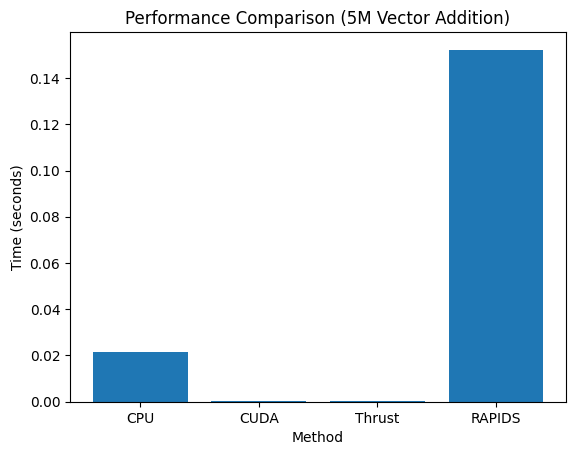

In [29]:
import matplotlib.pyplot as plt

methods = ["CPU", "CUDA", "Thrust", "RAPIDS"]
times = [0.0216518, 0.000314752, 0.00034192, 0.15226340293884277]  # Replace with real values

plt.bar(methods, times)
plt.xlabel("Method")
plt.ylabel("Time (seconds)")
plt.title("Performance Comparison (5M Vector Addition)")
plt.show()


Q6 Write a CUDA C++ program using the Thrust library to compute the sum ofall elements in a vector stored on the GPU. The vector is of size 10 and itshould be ini;alized with values 1,.....10.

In [30]:
%%writefile thrust_sum.cu
#include<thrust/device_vector.h>
#include<thrust/reduce.h>
#include<iostream>

int main(){

    thrust::device_vector<int> d(10);

    for(int i=0;i<10;i++)
        d[i]=i+1;

    int sum = thrust::reduce(d.begin(), d.end());

    std::cout<<"Sum = "<<sum<<std::endl;

    return 0;
}


Writing thrust_sum.cu


In [31]:
!nvcc -arch=sm_75 thrust_sum.cu -o thrust_sum

In [32]:
!./thrust_sum

Sum = 55


Q7 Write a CUDA C++ program using Thrust to sort (ascending) a vector of integers on the GPU. Consider vector size 8 with following values: 7, 2, 9, 1,5, 3, 8, 4. Print the vector before and afer sorting.

In [33]:
%%writefile thrust_sort.cu
#include<thrust/device_vector.h>
#include<thrust/sort.h>
#include<iostream>

int main(){

    int arr[8] = {7,2,9,1,5,3,8,4};

    thrust::device_vector<int> d(arr, arr+8);

    std::cout<<"Before Sorting:\n";
    for(int i=0;i<8;i++)
        std::cout<<d[i]<<" ";

    std::cout<<std::endl;

    thrust::sort(d.begin(), d.end());

    std::cout<<"After Sorting:\n";
    for(int i=0;i<8;i++)
        std::cout<<d[i]<<" ";

    std::cout<<std::endl;

    return 0;
}


Writing thrust_sort.cu


In [34]:
!nvcc -arch=sm_75 thrust_sort.cu -o thrust_sort

In [35]:
!./thrust_sort

Before Sorting:
7 2 9 1 5 3 8 4 
After Sorting:
1 2 3 4 5 7 8 9 
